In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
# 因为要做二分类，所以重新映射一下
label_map = {0: 0, 2: 1}

class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
# 模型结构
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # <1> 3*32*32
                512,   # <2>
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2>
                n_out, # <3>
            )
        )

In [7]:
def softmax(x): # x为向量
    # 即 x本身的e指数除以所有x的指数和
    return torch.exp(x) / torch.exp(x).sum() # 返回的也是同形状的向量

In [8]:
l = torch.Tensor([10,50,-50,20])
softmax(l) # 和是1

tensor([4.2484e-18, 1.0000e+00, 3.7835e-44, 9.3576e-14])

In [9]:
softmax = nn.Softmax(dim=1) # 即对每一组数据做预测

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, -3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.2676, 0.7275, 0.0049]])

In [10]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


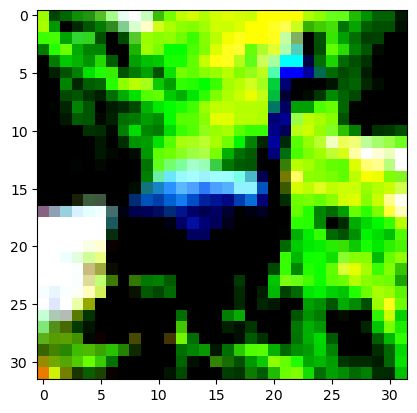

In [11]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [12]:
# 先合并为一维（配合模型的输入）
img_batch = img.view(-1) 
img_batch.shape

torch.Size([3072])

In [13]:
# 再添加batch的维度
img_batch = img_batch.unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [14]:
# 此时模型未训练，输出是随机的
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [15]:
_, index = torch.max(out, dim=1)

_, index

(tensor([0.5216], grad_fn=<MaxBackward0>), tensor([1]))

In [16]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])

# index的长度跟batch的大小相关，在每个batch中分别给出每一组数据的index
_, index = torch.max(out, dim=1)
index

tensor([0, 0, 1, 1])

In [17]:
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)
class_index,class_index.shape

(tensor([[0],
         [0],
         [1],
         [1]]),
 torch.Size([4, 1]))

In [18]:
# one-hot处理
truth = torch.zeros((4,2))
# 在truth中，将index值为class_index的元素赋值为value（1）
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [19]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [20]:
print(out)
out.gather(dim=1, index=class_index) # 获取对应index的值

tensor([[0.6000, 0.4000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])


tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [21]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [22]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [23]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)


tensor([[0., 1.]])

In [24]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [25]:
log_softmax(x)

tensor([[-104.,    0.]])

In [26]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [27]:
# 为了避免上面几个cell所示的极端情况，即靠近0时的概率数值过小，pytorch中一般使用nn.LogSoftmax(dim=1)作为激活层

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [28]:
# 对应的loss要使用NLLLoss()
loss = nn.NLLLoss()

In [30]:
img, label = cifar2[0]
print(label)
out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))# label需要转换为tensor并加一维

1


tensor(0.5077, grad_fn=<NllLossBackward0>)

In [31]:
# train

import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2: # 每次一个图一个图取
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 7.933513
Epoch: 10, Loss: 2.918774
Epoch: 20, Loss: 10.234636
Epoch: 30, Loss: 10.105783
Epoch: 40, Loss: 11.030375
Epoch: 50, Loss: 9.631423
Epoch: 60, Loss: 14.780630
Epoch: 70, Loss: 1.849473
Epoch: 80, Loss: 11.972377
Epoch: 90, Loss: 8.444486


In [32]:
# pytorch要使用dataloader
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.447263
Epoch: 10, Loss: 0.428689
Epoch: 20, Loss: 0.275151
Epoch: 30, Loss: 0.219033
Epoch: 40, Loss: 0.218461
Epoch: 50, Loss: 0.148022
Epoch: 60, Loss: 0.081440
Epoch: 70, Loss: 0.023792
Epoch: 80, Loss: 0.027209
Epoch: 90, Loss: 0.027187


In [34]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999200


In [35]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.814000


In [ ]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1)) # 如果不添加最后的激活层，损失函数就要使用交叉熵，见下个cell

In [36]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [37]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.442122
Epoch: 1, Loss: 0.564187
Epoch: 2, Loss: 0.556502
Epoch: 3, Loss: 0.362519
Epoch: 4, Loss: 0.328871
Epoch: 5, Loss: 0.269756
Epoch: 6, Loss: 0.588623
Epoch: 7, Loss: 0.289391
Epoch: 8, Loss: 0.195039
Epoch: 9, Loss: 0.736127
Epoch: 10, Loss: 0.317127
Epoch: 11, Loss: 0.274354
Epoch: 12, Loss: 0.159522
Epoch: 13, Loss: 0.216967
Epoch: 14, Loss: 0.216799
Epoch: 15, Loss: 0.292379
Epoch: 16, Loss: 0.543396
Epoch: 17, Loss: 0.445430
Epoch: 18, Loss: 0.309119
Epoch: 19, Loss: 0.515323
Epoch: 20, Loss: 0.382812
Epoch: 21, Loss: 0.184163
Epoch: 22, Loss: 0.395992
Epoch: 23, Loss: 0.409924
Epoch: 24, Loss: 0.202520
Epoch: 25, Loss: 0.268749
Epoch: 26, Loss: 0.107136
Epoch: 27, Loss: 0.121309
Epoch: 28, Loss: 0.281326
Epoch: 29, Loss: 0.117399
Epoch: 30, Loss: 0.130109
Epoch: 31, Loss: 0.441064
Epoch: 32, Loss: 0.206699
Epoch: 33, Loss: 0.113586
Epoch: 34, Loss: 0.054658
Epoch: 35, Loss: 0.221755
Epoch: 36, Loss: 0.220723
Epoch: 37, Loss: 0.044560
Epoch: 38, Loss: 0.064

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [39]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.812500
